## Purpose: 

Running saved models, getting predictions and analyzing deforestration in Bolivia over the years 


In [1]:
# Import packages
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import PIL
import pathlib
import os
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *
import requests
!pip install pyunpack patool
import pyunpack
import matplotlib.pyplot as plt
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import sys
from tensorflow.keras.preprocessing.image import ImageDataGenerator

!pip install rarfile segmentation-models git+https://github.com/davej23/image-segmentation-keras.git rioxarray
# from rarfile import RarFile
# import segmentation_models as sm
# from keras_segmentation.models import segnet
# from keras.applications import vgg16
from sklearn.metrics import *
!pip install rioxarray
import rioxarray as rxr

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

from keras.utils import register_keras_serializable
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import os


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.7/93.7 kB 1.4 MB/s eta 0:00:00
  Cloning https://github.com/davej23/image-segmentation-keras.git to /tmp/pip-req-build-4izcngmk
  Running command git clone --filter=blob:none --quiet https://github.com/davej23/image-segmentation-keras.git /tmp/pip-req-build-4izcngmk
  Resolved https://github.com/davej23/image-segmentation-keras.git to commit e01b0a8d5859854cd9d259a618829889166439f5
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.1/301.1 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 41.0 MB/s eta 0:00:00
  Created wheel for keras-segmentation: filename=keras_segmentation-0.3.0-py3-none

In [7]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.14.0


In [15]:

# Custom IoU metric that was used in the running of the models:

@register_keras_serializable()
def mean_iou(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * K.round(y_pred)))
    union = K.sum(K.abs(y_true) + K.abs(K.round(y_pred)) - y_true * K.round(y_pred))
    iou = intersection / (union + K.epsilon())
    return iou

In [ ]:
# Loading saved model:
loaded_model = load_model("/content/drive/MyDrive/Deep Learning final project/final_models/model_unet.keras")

In [10]:
'''
  Returns an image plot of mask prediction
'''

def reconstruct_image(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])
  # Standardise between 0-1
  reconstruction = reconstruction/np.max(reconstruction)

  # Round to 0-1, binary pixel-by-pixel classification
  if rounded:
    reconstruction = np.round(reconstruction)

  # Plot reconstructed mask (prediction)
  plt.imshow(reconstruction)

In [11]:
'''
  Returns array of mask prediction, given model and image
'''
def reconstruct_array(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])

  if rounded:
    reconstruction = np.round(reconstruction)


  return reconstruction # Returns array

In [26]:
# Defining function to plot ground truth and predictions side by side: 

def plotting_ground_truth_and_predictions(file_path, model = loaded_model, super_title = ""):

"""Purpose: Easy visualizations and reduce redundancy 
Inputs: Path to original file, model for prediction, super_title for grpah, if needed 
Output: Printing of final plot """

# Processing images:
  # Opening file:
  a = (np.array(rxr.open_rasterio(file_path)))
  # Normalizing:
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  # Reshaping:
  output_size = (512, 512)
  reshaped_image = cv2.resize(a.transpose(1, 2, 0), output_size)
  reshaped_image = reshaped_image[:, :, :3]
  reshaped_image = reshaped_image[np.newaxis, :, :, :]
  squeezed_img = np.squeeze(reshaped_image)
  # Predicting
  predicted_image = reconstruct_array(model, reshaped_image, rounded=False)
  # Plotting:
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  # Plotting ground truth:
  axes[0].imshow(squeezed_img)
  axes[0].set_title('Ground Truth')
  axes[0].axis('off')
  # Plotting predictions:
  axes[1].imshow(predicted_image, cmap = 'gray')
  axes[1].set_title('Predicted Mask')
  axes[1].axis('off')
  # Adjusting layout
  plt.tight_layout()
  # Adding title:
  plt.suptitle(super_title)
  # Showing the plot
  plt.show()

1/1 [==============================] - 8s 8s/step


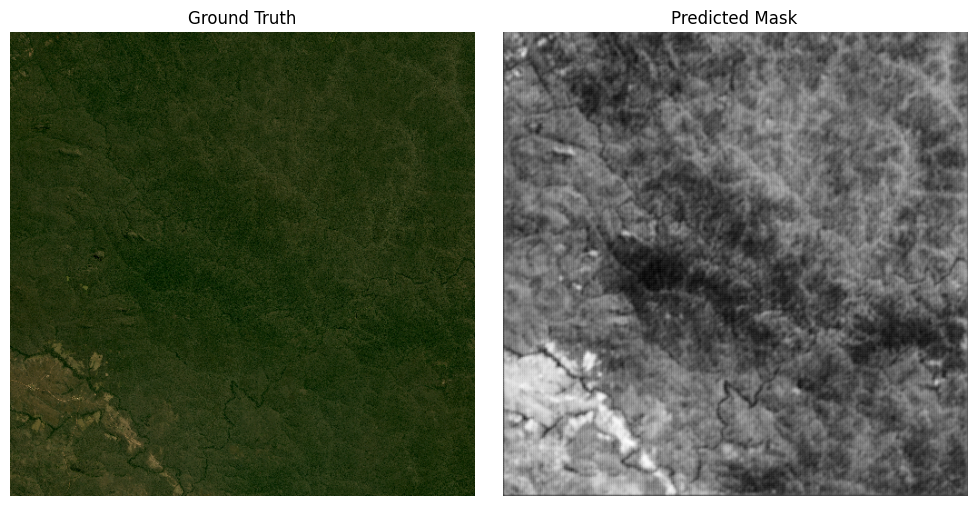

1/1 [==============================] - 7s 7s/step


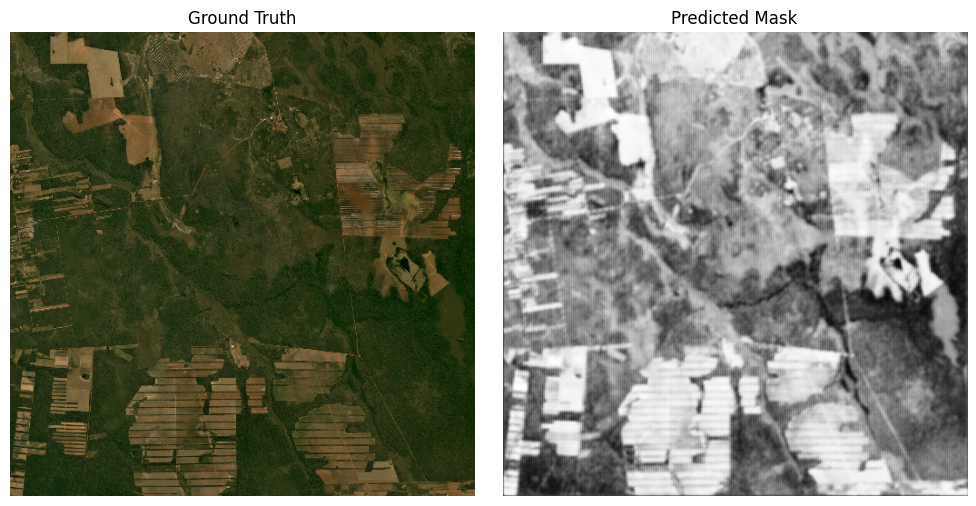

1/1 [==============================] - 10s 10s/step


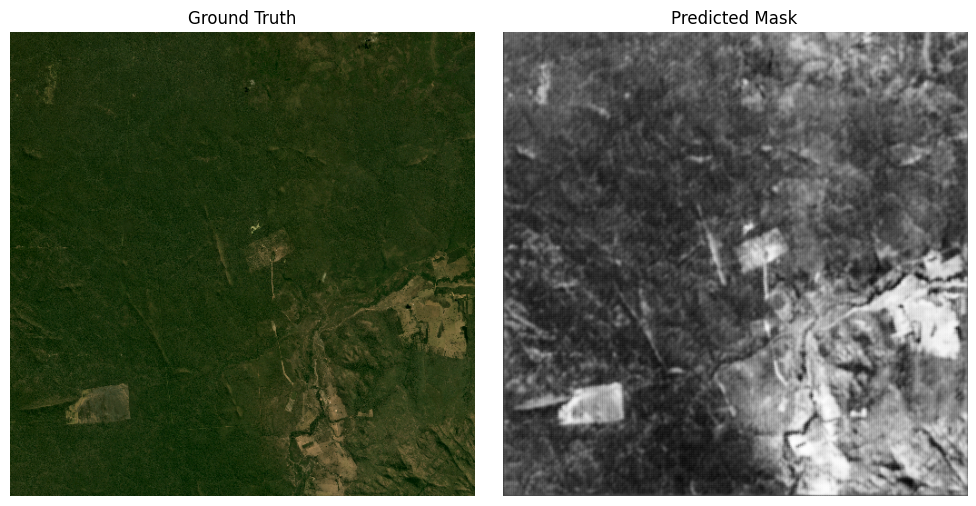

1/1 [==============================] - 9s 9s/step


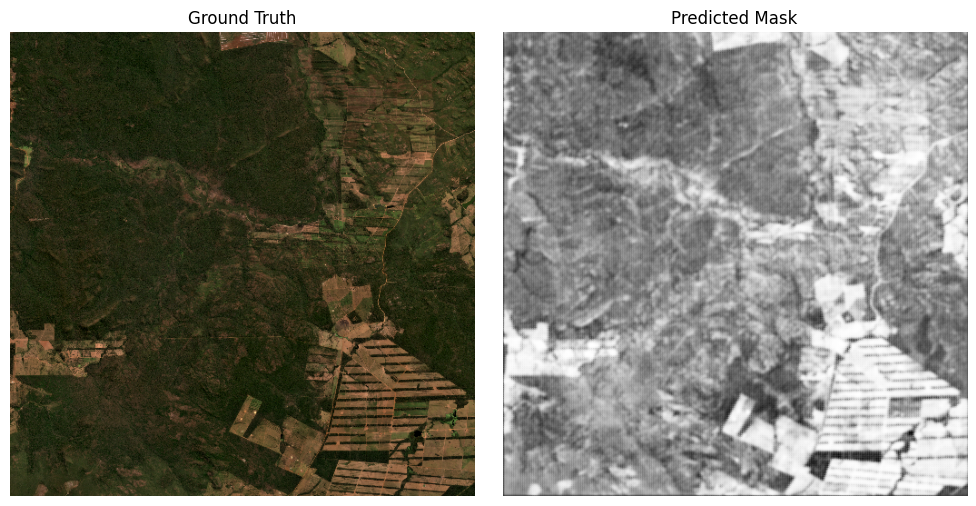

In [28]:
# Test runs for select images:
bolivia_path = "/content/drive/MyDrive/Deep Learning final project/Limited scope of research for presentation/2years_visual_full/planet_medres_visual_2017-06_2017-11_mosaic_672-928.tif"
plotting_ground_truth_and_predictions(bolivia_path, model = loaded_model)
bolivia_path = "/content/drive/MyDrive/Deep Learning final project/Limited scope of research for presentation/2years_visual_full/planet_medres_visual_2017-06_2017-11_mosaic_674-931.tif"
plotting_ground_truth_and_predictions(bolivia_path, model = loaded_model)
bolivia_path = "/content/drive/MyDrive/Deep Learning final project/Limited scope of research for presentation/2years_visual_full/planet_medres_visual_2017-06_2017-11_mosaic_676-933.tif"
plotting_ground_truth_and_predictions(bolivia_path, model = loaded_model)
bolivia_path = "/content/drive/MyDrive/Deep Learning final project/Limited scope of research for presentation/2years_visual_full/planet_medres_visual_2023-08_mosaic_676-932.tif"
plotting_ground_truth_and_predictions(bolivia_path, model = loaded_model)


In [34]:
# Running it for all images we aquired through Planet API and saving required metrics in a dictionary:

file_path = "/content/drive/MyDrive/Deep Learning final project/Limited scope of research for presentation/2years_visual_full"

empty_dict = {}

for image in tqdm(os.listdir(file_path)):

  a = (np.array(rxr.open_rasterio(file_path + "/" + image)))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))

  output_size = (512, 512)

  reshaped_image = cv2.resize(a.transpose(1, 2, 0), output_size)
  reshaped_image = reshaped_image[:, :, :3]
  reshaped_image = reshaped_image[np.newaxis, :, :, :]

  predicted_image = reconstruct_array(loaded_model, reshaped_image, rounded=False)

  empty_dict[image] = np.sum(predicted_image)


  0%|          | 0/72 [00:00<?, ?it/s]

1/1 [==============================] - 7s 7s/step


In [93]:
# Processing results into easily manipulatable pandas dataframe:

results = pd.DataFrame.from_dict(empty_dict, orient='index')
results = results.reset_index()
results = results.set_axis(['name', "np_sum"], axis=1)
results["year"] = [x.split('_')[3][:4] for x in results["name"]]
results["region"] = [x.split('_')[-1][:7] for x in results["name"]]
results.head()

,name,np_sum,year,region
0,planet_medres_visual_2023-08_mosaic_672-933.tif,206080.703125,2023,672-933
1,planet_medres_visual_2023-08_mosaic_673-933.tif,202715.843750,2023,673-933
2,planet_medres_visual_2023-08_mosaic_674-933.tif,199628.796875,2023,674-933
3,planet_medres_visual_2023-08_mosaic_675-933.tif,177291.500000,2023,675-933
4,planet_medres_visual_2023-08_mosaic_676-933.tif,191417.328125,2023,676-933


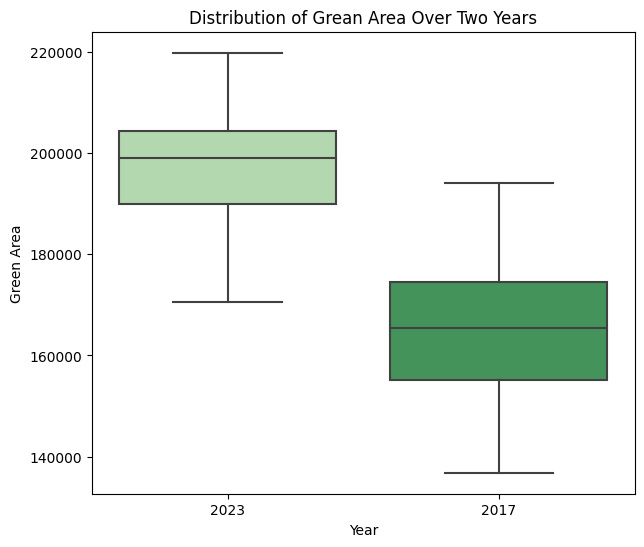

In [91]:
# Plotting distribution of non-green areas 

# Creating boxplots
plt.figure(figsize=(7, 6))
sns.boxplot(x=results.year, y=results.np_sum, palette='Greens')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Green Area')
plt.title('Distribution of Non-Green Area Over Two Years')

# Showing the plot
plt.show()
